# Least Square Estimation of AR Models and Whitening - Part I
---

Consider an $p$-order stationary autoregressive model driven by white noise.

$$ x_n = \sum_{k=1}^{p} a_kx_{n-k} + \epsilon_n $$

where, $\epsilon_n$ is Gaussian white noise with zero mean and variance $\sigma_{\epsilon}^2$.

Let us assume that we have $N+$ sample of this AR process and we are interested in estimating the parameter $a_k$. We can arrange the data into a set of $M=N+1-p$ linear equations,

$$ \begin{bmatrix}
x_{0} & x_{1} & \cdots & x_{p-1} \\
x_{1} & x_{2} & \cdots & x_{p} \\
x_{2} & x_{3} & \cdots & x_{p+1} \\
% x_{p+1} & x_{p} & \cdots & x_{2} \\
\vdots & \vdots & \ddots & \vdots \\
x_{N-p} & x_{N-p+1} & \cdots & x_{N-1}
\end{bmatrix} \begin{bmatrix}
a_p \\
a_{p-1} \\
\vdots \\
a_1
\end{bmatrix} = \begin{bmatrix}
x_{p}\\
x_{p+1}\\
x_{p+2}\\
\vdots\\
x_{N}
\end{bmatrix}
$$

$$ \begin{bmatrix}
\mathbf{x}_{N-p, M} & \mathbf{x}_{N-p+1, M} & \cdots & \mathbf{x}_{N-1, M}
\end{bmatrix} \mathbf{a} = \mathbf{x}_{N, M}
$$

$$ \mathbf{X}_{N, M}\mathbf{a} = \mathbf{x}_{N, M} $$

where, $\mathbf{x}_{k, M}$ is a column vector whose elements are the past $M$ of $x_n$ starting from the instant $k$; $x_{k-M+1}$, $x_{k}$ are the first and last elements of the vector, respectively. $\mathbf{X}_{N, M}$ consists of the columns $\mathbf{x}_{N-p, M}, \,\mathbf{x}_{N-p+1, M}, \, \ldots \, , \mathbf{x}_{N-p, M}$.

The least-squares estimate of $\mathbf{a}$ is given by,

$$ \hat{\mathbf{a}} = \left(\mathbf{X}_{N, M}^T\mathbf{X}_{N, M}\right)^{-1}\mathbf{X}_{N, M}^T\mathbf{x}_{N, M}
$$

Post-multiplying $\mathbf{x}_{N, M}$ by the pseudo-inverse will provide the least square estimate of $\mathbf{a}$.

**A simple example**: Let us start with the simplest possible example of a AR process where $p=1$.

$$ x_n = a_1 x_{n-1} + \epsilon_n $$

Lets assume that we have $N$ samples of $x_n$, we can then estimate the parameter $a_1$ using the following,

$$ \hat{a}_1 = \frac{\mathbf{x}_{N-1, M}^T\mathbf{x}_{N, M}}{\mathbf{x}_{N, M}^T\mathbf{x}_{N, M}}$$

### Estimation of a AR process of order 1 using the entire dataset

AR parameters
  Original |  Estimated
-------------------------
  -0.42982 |   -0.42862


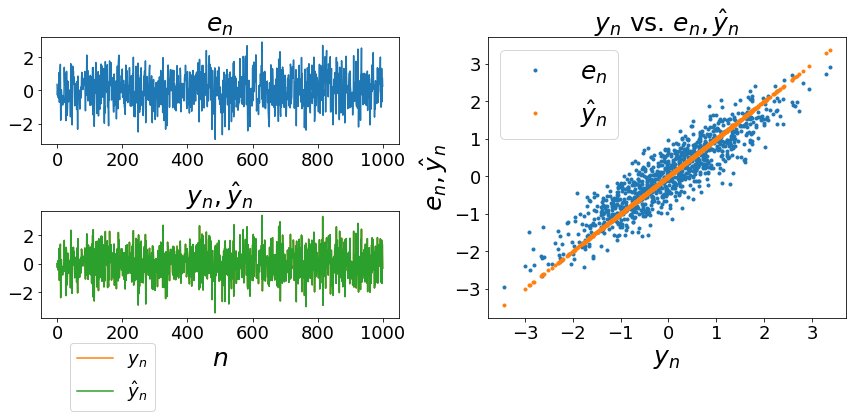

In [23]:
_ = genEstARProc(p=1, N=1000)

**Running estimate of AR parameters**: Instead of using the entire data set, a "running" estimate can be carried out by using a window (length $L$) of past data at any time instant $n$. Here would get an estimate for the AR parameters at each time instant $n$,
$$ \hat{\mathbf{a}}_n = \left(\mathbf{X}_{n, L}^T\mathbf{X}_{n, L}\right)^{-1}\mathbf{X}_{n, L}^T\mathbf{x}_{n, L}
$$


### Running estimate of a AR process of order 1

[ 0.         -1.41358076 -1.56933202 ...  0.89731138  1.86661959
  0.04383174]


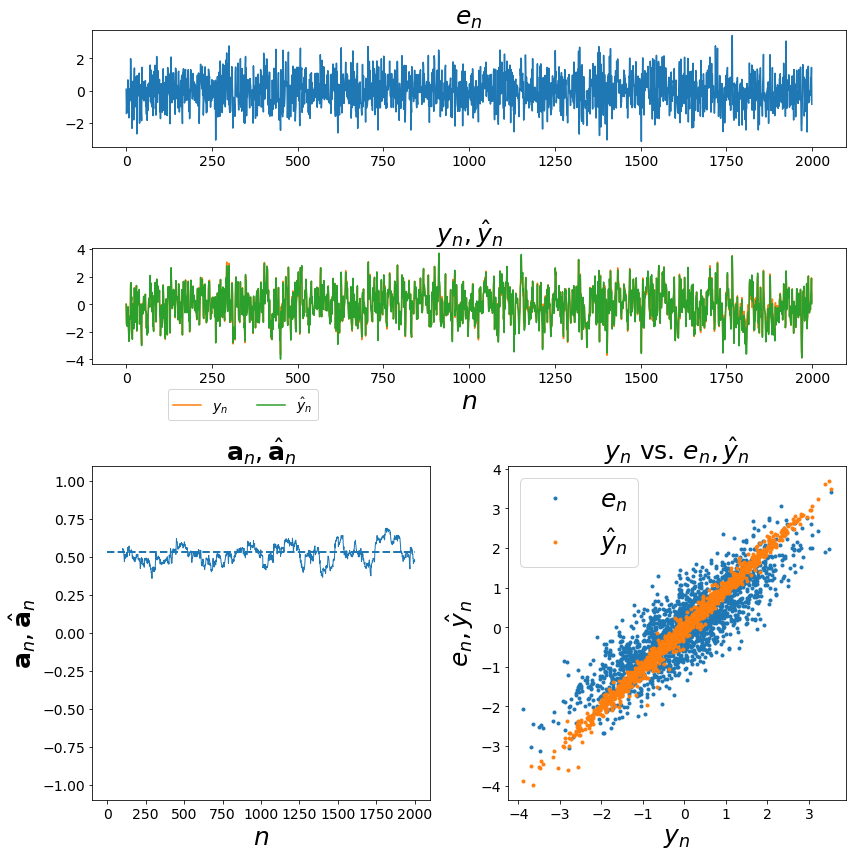

In [163]:
_ = genRunEstARProc(p=1, N=2000, L=100, dL=1, eparam=(0, 1.0))

## Running estimate of a order 'p' process

[ 0.          0.          0.         ... -0.71112412  0.80561295
  0.80775621]


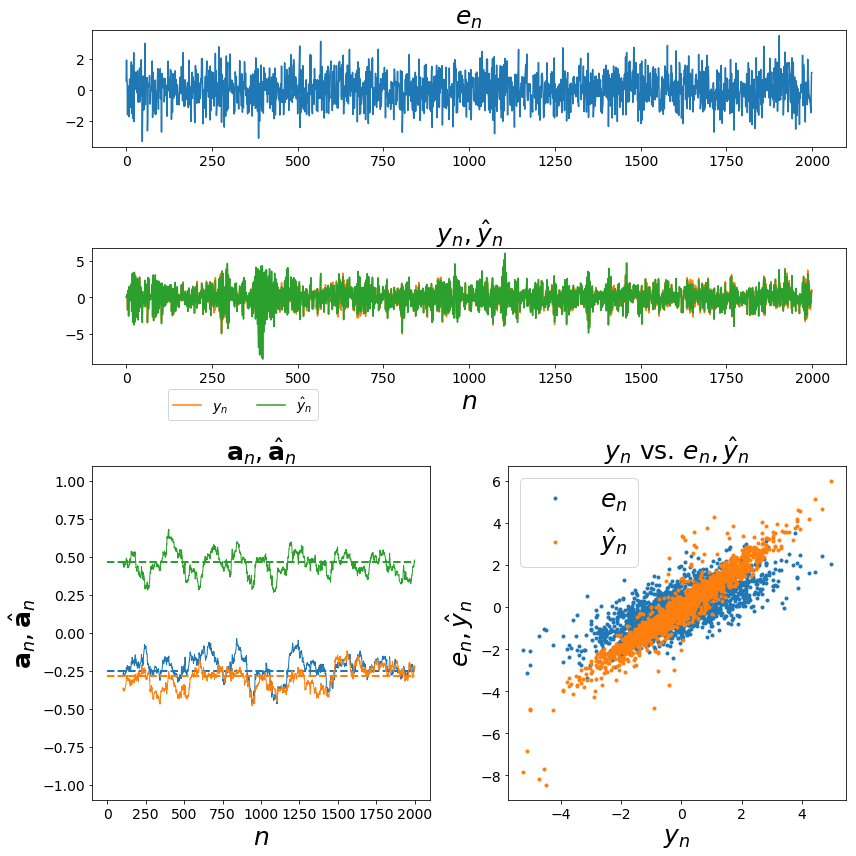

In [167]:
_ = genRunEstARProc(p=3, N=2000, L=100, dL=1, eparam=(0, 1.0));

## Whitening using estimated AR parametes $\left(\hat{a}\right)$

Once $\hat{a}$ is obtained, then the signal $y_n$ can be whitened by passing it through the following moving average filter.
$$w_n = y_n - \sum_{k=1}^{p} \hat{a}_ky_{n-k}$$

$w_n$ would be the out of this moving average filter, and $w_n$ will be a white noise. The input to this moving average filter the measured time series $y_n$.

In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [75]:
# Stationary AR process implementation
def genARProcess(a, e):
    N = len(e)
    p = len(a)
    # Generate the filtered signal
    y = np.zeros(N)
    for i in xrange(p, N):
        y[i] = e[i]
        for k in xrange(p):
            y[i] += a[k] * y[i - k - 1]
    return y

# Output of the AR process from time-varying parameters.
def genARProcessTimeVarParam(an, a, e):
    N = len(e)
    p = len(a)
    # Generate the filtered signal
    y = np.zeros(N)
    j = 0
    for i in xrange(p, N):
        y[i] = e[i]
        if (i > an[j]):
            j += 1
        for k in xrange(p):
            y[i] += a[k, j] * y[i - k - 1]
    return y

# Estimation of AR parameters.
def estARParam(p, y):
    N = len(y)
    ymat = np.zeros((N - p, p))
    yb = np.zeros((N - p - 1, 1))
    for c in xrange(p, 0, -1):
        ymat[:, p-c] = y[p-c:-c]
    yb = y[p:]
    return np.matmul(np.linalg.pinv(ymat), yb)[::-1]

# Running estimate of AR parameters.
def estRunARParam(p, y, L=None, dL=1):
    N = len(y)
    # Assign default window size
    if L is None:
        L = N - p
    arn = []
    arhat = []
    for _n in xrange(L+p-1, N, dL):
        arn.append(_n)
        arhat.append(estARParam(p, y[_n-L-p+1:_n+1]))
    # Always add a estimate using the last data.
    if (arn[-1] < N-1):
        arn.append(N-1)
        arhat.append(estARParam(p, y[N-L-p:N]))
    return np.array(arn), np.array(arhat).T

# Implementation of stationary whitening filter.
def whiten(y, ahat):
    N = len(y)
    p = len(ahat)
    w = np.zeros(N)
    for i in xrange(N):
        w[i] = y[i]
        for k in xrange(p):
            if i - k - 1 >= 0:
                w[i] += - ahat[k] * y[i - k - 1]
    return w

In [20]:
def genEstARProc(p, N=1000, eparam=(0, 1.0)):
    """
    """
    # AR parameters
    a = 1.8 * np.random.rand(p) - 0.9

    # Time series data
    n = np.arange(0, N)

    # Input white noise
    e = np.sqrt(eparam[1]) * np.random.randn(N) + eparam[0]

    # Generate AR time series.
    y = genARProcess(a, e)

    # Estimate autogressive model parameters
    ahat = estARParam(p, y)

    # Generate time series using estimated parameters
    yhat = genARProcess(ahat, e)
    
    # Plot results
    plot_arfit(n, e, y, yhat)

    # Original and estimated parameters
    print "AR parameters"
    print "  Original |  Estimated"
    print "-------------------------"
    for i in xrange(len(a)):
        print "{0:10.5f} | {1:10.5f}".format(a[i], ahat[i])
    
    return n, e, y, yhat, a, ahat

In [77]:
def genRunEstARProc(p=1, N=2000, L=None, dL=1, eparam=(0, 1.0)):
    """
    """
    # AR parameters
    a = 1.8 * np.random.rand(p) - 0.9

    # Time series data
    n = np.arange(0, N)

    # Input white noise
    e = np.sqrt(eparam[1]) * np.random.randn(N) + eparam[0]

    # Generate AR time series.
    y = genARProcess(a, e)

    # Estimate autogressive model parameters
    arn, arhat = estRunARParam(p, y, L=L, dL=dL)

    # Generate time series using estimated parameters
    yhat = genARProcessTimeVarParam(arn, arhat, e)
    
    plot_runarfit(n, e, y, yhat, a, arn, arhat)

    return n, e, y, yhat, a, arn, arhat

In [22]:
def plot_arfit(n, e, y, yhat):
    figure(figsize=(12, 6))
    subplot(221)
    plot(n, e, label="$e_n$")
    title("$e_n$", fontsize=25)
    xticks(fontsize=18)
    yticks(fontsize=18)

    subplot(223)
    plot(0,0)
    plot(n, y, label="$y_n$")
    plot(n, yhat, label="$\hat{y}_n$")
    xlabel("$n$", fontsize=25)
    legend(loc=9, bbox_to_anchor=(0.2, -0.15), ncol=1, fontsize=18)
    title("$y_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=18)
    yticks(fontsize=18)

    subplot(122)
    plot(y, e, '.', label="$e_n$")
    plot(y, yhat, '.', label="$\hat{y}_n$")
    legend(loc=2, fontsize=25)
    xlabel("$y_n$", fontsize=25)
    ylabel("$e_n, \hat{y}_n$", fontsize=25)
    title("$y_n$ vs. $e_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=18)
    yticks(fontsize=18)
    tight_layout();

In [101]:
def plot_runarfit(n, e, y, yhat, a, arn, ahat):
    figure(figsize=(12, 12))
    subplot2grid((4,2), (0, 0), rowspan=1, colspan=2)
    plot(n, e, label="$e_n$")
    title("$e_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)

    subplot2grid((4,2), (1, 0), rowspan=1, colspan=2)
    plot(0,0)
    plot(n, y, label="$y_n$")
    plot(n, yhat, label="$\hat{y}_n$")
    xlabel("$n$", fontsize=25)
    legend(loc=9, bbox_to_anchor=(0.2, -0.15), ncol=2, fontsize=14)
    title("$y_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)

    subplot2grid((4,2), (2, 0), rowspan=2, colspan=1)
    for i in xrange(len(a)):
        _p = plot(arn, ahat[i, :], lw=1)
        plot([0, n[-1]], [a[i], a[i]], '--', lw=2, color=(_p[-1].get_color()))
    ylim(-1.1, 1.1)
    xlabel("$n$", fontsize=25)
    ylabel("$\mathbf{a}_n, \hat{\mathbf{a}}_n$", fontsize=25)
    title("$\mathbf{a}_n, \hat{\mathbf{a}}_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)
    
    subplot2grid((4,2), (2, 1), rowspan=2, colspan=1)
    plot(y, e, '.', label="$e_n$")
    plot(y, yhat, '.', label="$\hat{y}_n$")
    legend(loc=2, fontsize=25)
    xlabel("$y_n$", fontsize=25)
    ylabel("$e_n, \hat{y}_n$", fontsize=25)
    title("$y_n$ vs. $e_n, \hat{y}_n$", fontsize=25)
    xticks(fontsize=14)
    yticks(fontsize=14)
    tight_layout();

In [9]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()